<a href="https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/Conceptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('BScThesis/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!pip3 install torch torchvision

In [35]:
!git clone https://github.com/wiatrak2/BScThesis

Cloning into 'BScThesis'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 245 (delta 33), reused 34 (delta 13), pack-reused 179
Receiving objects: 100% (245/245), 20.09 MiB | 8.67 MiB/s, done.
Resolving deltas: 100% (132/132), done.


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import pickle
import sympy
from collections import defaultdict, namedtuple
import copy

In [0]:
from mnist_m import Mnist_M
from datasets_merge import Merge_Datasets
import models
import trainer
import domain_trainer
from test_model import test_model
import plots
import test

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  return torch.from_numpy(np.tile(img, (3,1,1)))

In [0]:
batch_size=128
num_workers=1

In [0]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(convertMnist)
                       ])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)



In [0]:
def printMnist3D(image):
  image = image.numpy()
  image = image * 0.3081 + 0.1307
  plt.imshow(image.transpose(1,2,0), cmap='gray')

0


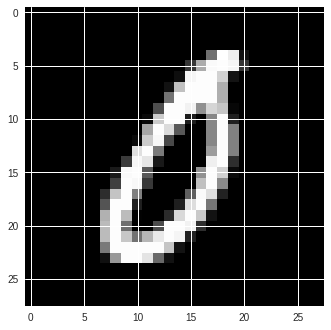

In [41]:
trainiter = iter(train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [0]:
log_interval = 100

In [0]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.01
momentum=0.9

In [0]:
mnist_m_transform = transforms.Compose([
                           transforms.Normalize(3*[0.1307], 3*[0.3081]),
                       ])
mnist_m_train = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',
                        transform=mnist_m_transform)
mnist_m_test = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',train=False,
                     transform=mnist_m_transform)
mnist_m_train_loader = torch.utils.data.DataLoader(mnist_m_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_m_test_loader = torch.utils.data.DataLoader(mnist_m_test,
                                                  batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)



tensor(0)


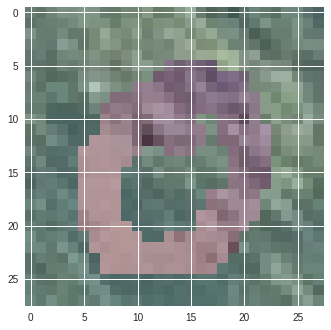

In [46]:
trainiter = iter(mnist_m_train_loader)
images, labels = trainiter.next()
printMnist3D(images[0])
print(labels[0])

In [0]:
Models = namedtuple('Models', ['model_f', 'model_c', 'model_d'])
Optims = namedtuple('Optims', ['optim_f', 'optim_c', 'optim_d'])
Criterions = namedtuple('Criterions', ['criterion', 'criterion_domain'])
Loaders = namedtuple('Loaders', ['train_loader', 'train_loader_domain',
                                'source_test_loader', 'target_test_loader',
                                'merged_test_loader'])

In [0]:
mnist_ext_train = Merge_Datasets([train_set, mnist_m_train])
mnist_ext_test = Merge_Datasets([test_set, mnist_m_test])
mnist_ext_train_loader = torch.utils.data.DataLoader(mnist_ext_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_ext_test_loader = torch.utils.data.DataLoader(mnist_ext_test, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)




In [0]:
loaders = Loaders(train_loader, mnist_m_train_loader,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader)

In [0]:
criterion = F.nll_loss
criterion_domain = F.nll_loss

In [0]:
criterions = Criterions(criterion, criterion_domain)

In [0]:
epochs=10

In [0]:
model_f = models.MnistFeatureExtractor().to(device)
model_c = models.MnistClassPredictor().to(device)
model_d = models.MnistDomain().to(device)
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum, nesterov=True)

train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer = trainer.Trainer(train_models, optims, criterions, device,
                                tune_lr=True)

In [55]:
test_history = defaultdict(lambda:[])
model_trainer.train(epochs, loaders, test_history=test_history)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.357388, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.632941, lr: 0.00865 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.429548, lr: 0.00766 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.250033, lr: 0.00690 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.385426, lr: 0.00630 lambd: 0.40253

Target Domain Test set: Average loss: 1.2514, Accuracy: 6144/10000 (61%)
Source Domain Test set: Average loss: 0.1199, Accuracy: 9655/10000 (97%)
Domains predictor:  Accuracy: 14880/20000 (74%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.236685, lr: 0.00595 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.274808, lr: 0.00551 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.328516, lr: 0.00514 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.177769, lr: 0.00483 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.488962, lr: 0.00455

In [0]:
def get_input_mtx(loader, model, c_size):
  X = np.zeros(c_size).T
  for batch_idx, (data, labels) in enumerate(loader):
    data = data.to(device)
    idx = batch_idx * loader.batch_size
    X[idx:idx+loader.batch_size] = model(data).cpu().detach().numpy()
  return X.T

In [0]:
def get_conceptor(X, alpha):
  R = np.matmul(X, X.T) * (1/X.shape[0])
  IdX = np.identity(X.shape[0])
  return np.matmul(R, np.linalg.inv((R + alpha**(-2) * IdX)))

In [0]:
def get_not_conceptor(C):
  return np.identity(C.shape[0]) - C

In [0]:
def get_or_from_X(X_i, X_j, alpha):
  IdX = np.identity(X_i.shape[0])
  R_i = np.matmul(X_i, X_i.T) * (1/X_i.shape[0])
  R_j = np.matmul(X_j, X_j.T) * (1/X_j.shape[0])
  return np.matmul(R_i + R_j, np.linalg.inv((R_i + R_j + alpha**(-2) * IdX)))

In [0]:
def get_R(C, alpha):
  U, S, U_T = np.linalg.svd(C)
  Sigma = (S * alpha**(-2)) / (1 - S)
  return U.dot(np.diag(Sigma).dot(U_T))

In [0]:
def get_or_conceptor(C_i, C_j, alpha):
  R_i, R_j = get_R(C_i, alpha), get_R(C_j, alpha)
  IdX = np.identity(C_i.shape[0])
  return np.matmul(R_i + R_j, np.linalg.inv((R_i + R_j + alpha**(-2) * IdX)))

In [0]:
def get_and_conceptor(C_i, C_j, alpha):
  not_C_i, not_C_j = get_not_conceptor(C_i), get_not_conceptor(C_j)
  or_not_C = get_or_conceptor(not_C_i, not_C_j, alpha)
  return get_not_conceptor(or_not_C)

In [0]:
X_mnist = get_input_mtx(train_loader, model_f, (320, len(train_set)))

In [0]:
alpha=9.

In [0]:
C_mnist = get_conceptor(X_mnist, alpha)

In [72]:
C_mnist.shape

(320, 320)

In [0]:
X_mnist_m = get_input_mtx(mnist_m_train_loader, model_f, (320, len(train_set)))

In [0]:
C_mnist_m = get_conceptor(X_mnist_m, alpha)

In [0]:
C_or = get_or_conceptor(C_mnist, C_mnist_m, alpha)

In [0]:
C_and = get_and_conceptor(C_mnist, C_mnist_m, alpha)

In [161]:
C_and

array([[ 9.99659299e-01,  4.29783510e-05, -9.93177907e-06, ...,
         7.71344374e-06,  1.00222110e-06,  3.86476956e-06],
       [ 4.29783510e-05,  9.99730957e-01,  8.26380208e-05, ...,
        -2.61621550e-06, -6.03509470e-07, -6.85824403e-06],
       [-9.93177907e-06,  8.26380208e-05,  9.99769482e-01, ...,
         1.25965123e-06, -1.90210440e-06, -3.34028605e-06],
       ...,
       [ 7.71344374e-06, -2.61621548e-06,  1.25965123e-06, ...,
         9.99578921e-01,  1.52518296e-04, -2.74671989e-05],
       [ 1.00222110e-06, -6.03509472e-07, -1.90210440e-06, ...,
         1.52518296e-04,  9.99576541e-01,  1.21770159e-04],
       [ 3.86476956e-06, -6.85824404e-06, -3.34028605e-06, ...,
        -2.74671989e-05,  1.21770159e-04,  9.99369819e-01]])

In [162]:
C_or

array([[ 9.99926449e-01,  9.61939424e-06, -2.98423987e-06, ...,
         1.21490363e-06, -2.78440523e-07,  6.61513752e-08],
       [ 9.61939424e-06,  9.99940282e-01,  1.89438153e-05, ...,
        -1.09769426e-06, -3.71269157e-07, -1.40773845e-06],
       [-2.98423987e-06,  1.89438153e-05,  9.99949223e-01, ...,
         4.21290392e-07, -4.61538053e-07, -9.19200107e-07],
       ...,
       [ 1.21490363e-06, -1.09769427e-06,  4.21290389e-07, ...,
         9.99903339e-01,  3.84448091e-05, -6.91624353e-06],
       [-2.78440523e-07, -3.71269157e-07, -4.61538055e-07, ...,
         3.84448091e-05,  9.99903402e-01,  3.00607910e-05],
       [ 6.61513748e-08, -1.40773846e-06, -9.19200108e-07, ...,
        -6.91624353e-06,  3.00607910e-05,  9.99864417e-01]])